This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np
import datetime

file_name = "./data/data_000637.txt"
df = pd.read_csv(file_name, nrows=None)
N = df.shape[0]
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [3]:
# when the value of bx_counter reaches the value x, it goes to zero and the orbit counter is increased by one.
# it's like minutes and hours. So we can estimate x by considering the maximum value of bx_counter plus one

bx_counter = df["BX_COUNTER"]
x = np.max(bx_counter) + 1 
print("The estimated value of x is", x)

The estimated value of x is 3564


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [4]:
#the data taking is ordered based on the time, so the first row is the first acquisition and the last row 
#is the last acquisition. So it sufficies to convert these two measurements in hours, minutes and seconds
#and then take the difference of the two

ns_beginning = (25/30)*df.loc[0, "TDC_MEAS"] + 25*df.loc[0, "BX_COUNTER"] + df.loc[0, "ORBIT_CNT"]*x*25
#this is the total number of ns for the first acquisition

ns_end = (25/30)*df.loc[N-1, "TDC_MEAS"] + 25*df.loc[N-1, "BX_COUNTER"] + df.loc[N-1, "ORBIT_CNT"]*x*25
#this is the total number of ns for the last acquisition

#so the total number of ns for data taking is
ns_total = ns_end - ns_beginning
print("ns total:", ns_total)

s_total = ns_total * (10**-9)
print("begin:", ns_beginning)
print("end:", ns_end)
print("total number of seconds:", s_total)
print("number of hours, minutes and seconds:", datetime.timedelta(seconds=s_total))

ns total: 980416093.3125
begin: 344745734939071.7
end: 344746715355165.0
total number of seconds: 0.9804160933125
number of hours, minutes and seconds: 0:00:00.980416


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [5]:
dfc = df.copy()
dfc["ABS_NS"] = (25/30)*df["TDC_MEAS"] + 25*df["BX_COUNTER"] + df["ORBIT_CNT"]*x*25
dfc

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_NS
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.447467e+14
1310716,1,1,4,3869211171,763,11,3.447467e+14
1310717,1,0,64,3869211171,764,0,3.447467e+14
1310718,1,0,139,3869211171,769,0,3.447467e+14


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
#creation of another column with the number of times each tdc_channel appears in the dataframe
dfc["COUNTS"] = dfc.groupby("TDC_CHANNEL")["TDC_CHANNEL"].transform('size')
new_df = dfc.sort_values(by='COUNTS', ascending=False).drop_duplicates(subset=['COUNTS'])
new_df.iloc[0:3, [2,7]]

,TDC_CHANNEL,COUNTS
138919,139,108059
276542,64,66020
463846,63,64642


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [7]:
orbits_df = dfc.drop_duplicates(subset=['ORBIT_CNT'])
#orbits_df
print("Number of non-empty orbits:", orbits_df.shape[0])

tdc = dfc[dfc['TDC_CHANNEL'] == 139]
non_duplicate_tdc = tdc.drop_duplicates(subset=['ORBIT_CNT'])
print("Number of unique orbits with at least one TDC_CHANNEL = 139:", non_duplicate_tdc.shape[0])

Number of non-empty orbits: 11001
Number of unique orbits with at least one TDC_CHANNEL = 139: 10976


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

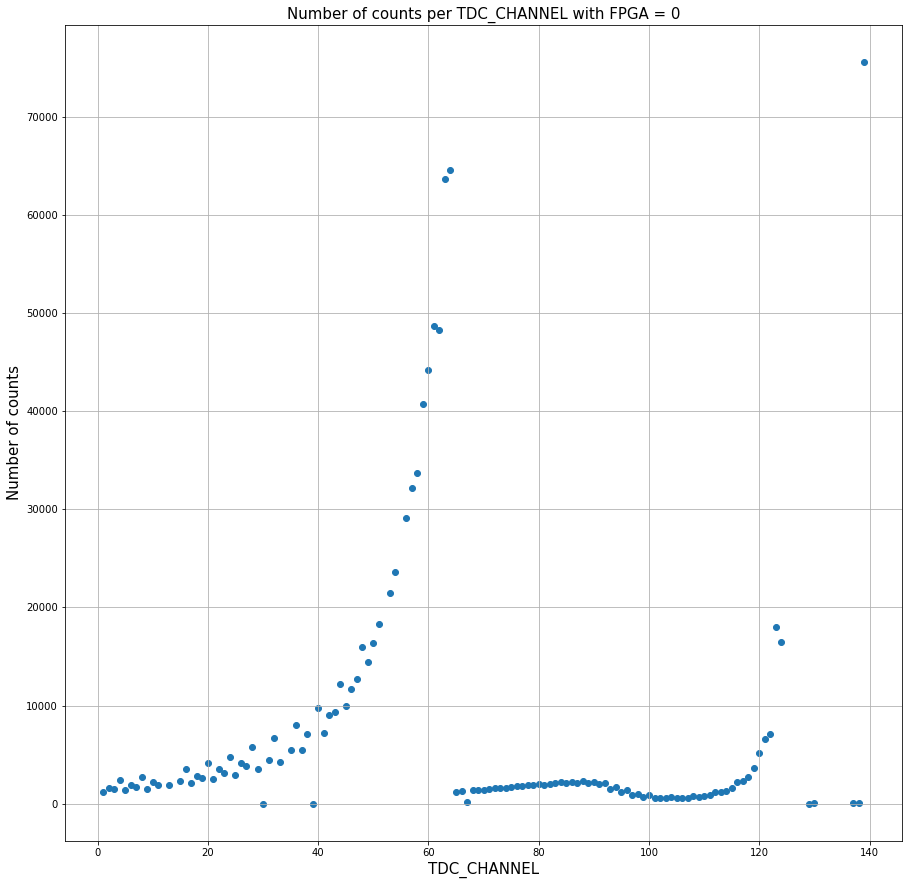

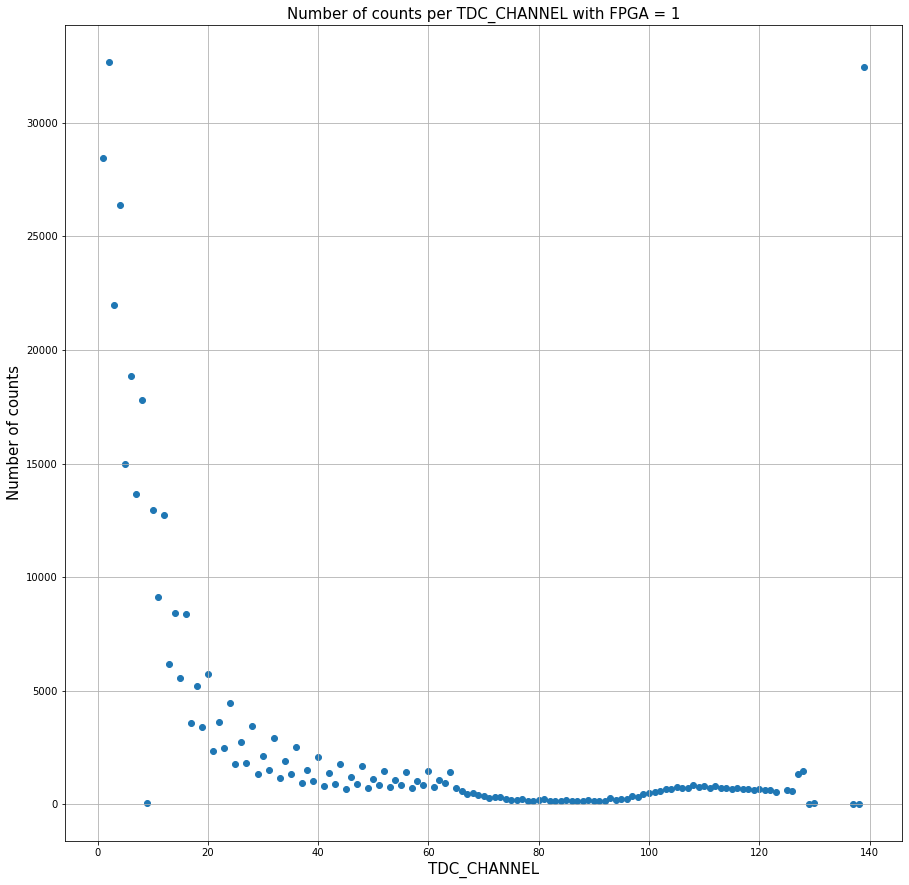

In [8]:
import matplotlib.pyplot as plt

new_df_1 = df[df['FPGA']==0]
new_df_2 = df[df['FPGA']==1]

final_df_1 = new_df_1.copy()
final_df_2 = new_df_2.copy()

final_df_1["COUNTS_FPGA0"] = new_df_1.groupby("TDC_CHANNEL")["TDC_CHANNEL"].transform('size')
final_df_2["COUNTS_FPGA1"] = new_df_2.groupby("TDC_CHANNEL")["TDC_CHANNEL"].transform('size')

final_df_1 = final_df_1.sort_values(by='TDC_CHANNEL', ascending=True).drop_duplicates(subset=['TDC_CHANNEL'])
final_df_2 = final_df_2.sort_values(by='TDC_CHANNEL', ascending=True).drop_duplicates(subset=['TDC_CHANNEL'])
final_df_1

#So now I have two dataframes that contains the tdc_channels, and the counts of them, based on the FPGA value
#I just need to plot the TDC_CHANNEL column vs the COUNTS_FPGA column

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(final_df_1['TDC_CHANNEL'], final_df_1['COUNTS_FPGA0'])
ax.set_xlabel('TDC_CHANNEL', fontsize = 15)
ax.set_ylabel('Number of counts', fontsize = 15)
ax.set_title('Number of counts per TDC_CHANNEL with FPGA = 0', fontsize = 15)
ax.grid()

fig2, ax2 = plt.subplots(figsize=(15,15))
ax2.scatter(final_df_2['TDC_CHANNEL'], final_df_2['COUNTS_FPGA1'])
ax2.set_xlabel('TDC_CHANNEL', fontsize = 15)
ax2.set_ylabel('Number of counts', fontsize = 15)
ax2.set_title('Number of counts per TDC_CHANNEL with FPGA = 1', fontsize = 15)
ax2.grid()
plt.show()